In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import chess
import torch
import torch.nn as nn
import torch.optim as optim

from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GroupShuffleSplit

In [8]:
# Vocabulary
def get_feature_vocabulary() -> list[str]:
    fresh_chess_board = chess.Board()
    # Get all unique characters in fresh_chess_board
    unique_terms = list(set(fresh_chess_board.board_fen()))
    unique_terms = [term for term in unique_terms if term.isalpha()]
    unique_terms.sort()
    unique_terms.insert(0, "EMPTY")
    return unique_terms

def get_target_categories() -> list[str]:
    # Read from ../data/processed/vocabulary_san.txt, key=word, value=index. For reverse_vocab, key=index, value=word
    with open("../data/processed/vocabulary_san.txt", "r") as file:
        vocab: list[str] = file.read().splitlines()
    return vocab

# Function to convert the board to a flat list
def board_to_flat_list(board):
    # Get the board as a string in ASCII format
    # Replace "." with None
    flat_list = [str(board.piece_at(i)) for i in range(64)]
    return flat_list


# Create dataset
def determine_game_stage(move_number):
    # 0-10 early game
    # 11-30 mid game
    # 31+ end game
    if move_number <= 10:
        return 1
    elif move_number <= 30:
        return 2
    else:
        return 3


def create_dataset(lichess_username: str) -> pd.DataFrame:
    data_df = pd.read_csv(f"../data/raw/games_{lichess_username}.csv")
    output_df = pd.DataFrame()
    game_list = []

    game_id_stage_count_map = {}
    for game_id in data_df["game_id"].unique():
        game_id_stage_count_map[str(game_id)] = 0

    for idx, row in data_df.iterrows():
        game_id = str(row.get("game_id"))
        white_player = row.get("white_player")
        move_list = row.get("move_list")

        if isinstance(move_list, float):
            continue

        move_list = move_list.split(" ")

        generator_start_index = 0 if white_player == lichess_username else 1
        for move_idx in range(generator_start_index, len(move_list), 2):
            game_id_stage_count_map[game_id] += 1
            move_number = game_id_stage_count_map.get(game_id)
            game_stage = determine_game_stage(move_number)

            target_move = move_list[move_idx]
            input_sequence_list = move_list[:move_idx]

            board = chess.Board()
            for input_move in input_sequence_list:
                board.push_san(input_move)

            board_flat_list = [game_id]
            board_flat_list.extend(board_to_flat_list(board))
            board_flat_list.append(game_stage)
            board_flat_list.append(target_move)
            game_list.append(board_flat_list)

    output_df = pd.DataFrame(game_list)
    # Rename first col to game_id and last col to target_move
    output_df = output_df.rename(
        columns={
            0: "game_id",
            len(output_df.columns)-1: "target_move",
            len(output_df.columns)-2: "game_stage"
        }
    )

    # Add number of remaining backline pieces for both players
    backline_case_black_set = set(['b', 'k', 'n', 'p', 'q', 'r'])
    backline_case_white_set = set(['B', 'K', 'N', 'P', 'Q', 'R'])
    output_df["white_backline"] = output_df.apply(
        lambda row: len([piece for piece in row[1:65] if piece in backline_case_white_set]),
        axis=1
    )
    output_df["black_backline"] = output_df.apply(
        lambda row: len([piece for piece in row[1:65] if piece in backline_case_black_set]),
        axis=1
    )
    return output_df

# For all values in X, transform string to int using vocabulary_dict
def encode_df(df: pd.DataFrame, feature_categories: list[str], target_categories: list[str]) -> pd.DataFrame:    
    # Encode cells of columns 1-65 using feature_categories, key=term, value=index
    for col in range(1, 65):
        df[col] = df[col].replace("None", "EMPTY")
        # IMPORTANT: +1 to all values to avoid 0 index so that matrix multiplication can be done in NN
        df[col] = df[col].apply(lambda x: feature_categories.index(x)+1)

    # Key value pair for target_categories, key=term, value=index
    target_categories_dict = {val: idx for idx, val in enumerate(target_categories)}

    # Encode column target_move using target_categories, key=term, value=index
    df["target_move"] = df["target_move"].apply(lambda x: target_categories_dict[x])
    return df

In [9]:
LICHESS_USERNAME = "ritutoshniwal"

feature_categories = get_feature_vocabulary()
print(f"Feature categories: {feature_categories}\n")

target_categories = get_target_categories()
print(f"Target categories sample: {target_categories[:5]}\nFull length: {len(target_categories)} terms")

# Create dataset
dataset = create_dataset(LICHESS_USERNAME)
print("\nBefore encoding:")
display(dataset)

encoded_df = encode_df(dataset, feature_categories, target_categories)
print("\nAfter encoding:")
display(encoded_df)

Feature categories: ['EMPTY', 'B', 'K', 'N', 'P', 'Q', 'R', 'b', 'k', 'n', 'p', 'q', 'r']

Target categories sample: ['a2', 'a3', 'a4', 'a5', 'a6']
Full length: 29274 terms

Before encoding:


,game_id,1,2,3,4,5,6,7,8,9,...,59,60,61,62,63,64,game_stage,target_move,white_backline,black_backline
0,UWNtHs0N,R,N,B,Q,K,B,N,R,P,...,b,q,k,b,n,r,1,e5,16,16
1,UWNtHs0N,R,N,B,Q,K,None,N,R,P,...,b,q,k,b,n,r,1,Nc6,16,16
2,UWNtHs0N,R,N,B,None,K,None,N,R,P,...,b,q,k,b,n,r,1,h6,16,16
3,vYvlCtTz,R,N,B,Q,K,B,N,R,P,...,b,q,k,b,n,r,1,e4,16,16
4,vYvlCtTz,R,N,B,Q,K,B,N,R,P,...,b,q,k,b,n,r,1,Bc4,16,16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54064,pi0Lnt2h,None,None,None,None,None,None,K,None,None,...,None,None,None,None,None,None,3,Re6+,6,4
54065,pi0Lnt2h,None,None,None,None,None,None,K,None,None,...,None,None,None,None,None,None,3,Nb5,6,4
54066,pi0Lnt2h,r,None,None,None,None,None,K,None,None,...,None,None,None,None,None,None,3,Kg2,6,4
54067,pi0Lnt2h,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,3,Nc3,6,4



After encoding:


,game_id,1,2,3,4,5,6,7,8,9,...,59,60,61,62,63,64,game_stage,target_move,white_backline,black_backline
0,UWNtHs0N,7,4,2,6,3,2,4,7,5,...,8,12,9,8,10,13,1,27,16,16
1,UWNtHs0N,7,4,2,6,3,1,4,7,5,...,8,12,9,8,10,13,1,197,16,16
2,UWNtHs0N,7,4,2,1,3,1,4,7,5,...,8,12,9,8,10,13,1,46,16,16
3,vYvlCtTz,7,4,2,6,3,2,4,7,5,...,8,12,9,8,10,13,1,26,16,16
4,vYvlCtTz,7,4,2,6,3,2,4,7,5,...,8,12,9,8,10,13,1,67,16,16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54064,pi0Lnt2h,1,1,1,1,1,1,3,1,1,...,1,1,1,1,1,1,3,3842,6,4
54065,pi0Lnt2h,1,1,1,1,1,1,3,1,1,...,1,1,1,1,1,1,3,188,6,4
54066,pi0Lnt2h,13,1,1,1,1,1,3,1,1,...,1,1,1,1,1,1,3,161,6,4
54067,pi0Lnt2h,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,3,194,6,4


In [10]:
scaled_df = encoded_df.copy()
# Rename cols 1-65 to cell1, cell2, ..., cell64
scaled_df = scaled_df.rename(columns={i: f"cell{i}" for i in range(1, 65)})

for i in range(1, 65):
    scaled_df[f"cell{i}"] = scaled_df[f"cell{i}"].astype(float)
scaled_df["game_stage"] = scaled_df["game_stage"].astype(float)
scaled_df["white_backline"] = scaled_df["white_backline"].astype(float)
scaled_df["black_backline"] = scaled_df["black_backline"].astype(float)

features_df = scaled_df.drop(columns=["game_id", "target_move"])
target_df = scaled_df["target_move"]

display(features_df.head())
display(target_df.head())
    
scaler = StandardScaler()
features = scaler.fit_transform(features_df)

,cell1,cell2,cell3,cell4,cell5,cell6,cell7,cell8,cell9,cell10,...,cell58,cell59,cell60,cell61,cell62,cell63,cell64,game_stage,white_backline,black_backline
0,7.0,4.0,2.0,6.0,3.0,2.0,4.0,7.0,5.0,5.0,...,10.0,8.0,12.0,9.0,8.0,10.0,13.0,1.0,16.0,16.0
1,7.0,4.0,2.0,6.0,3.0,1.0,4.0,7.0,5.0,5.0,...,10.0,8.0,12.0,9.0,8.0,10.0,13.0,1.0,16.0,16.0
2,7.0,4.0,2.0,1.0,3.0,1.0,4.0,7.0,5.0,5.0,...,1.0,8.0,12.0,9.0,8.0,10.0,13.0,1.0,16.0,16.0
3,7.0,4.0,2.0,6.0,3.0,2.0,4.0,7.0,5.0,5.0,...,10.0,8.0,12.0,9.0,8.0,10.0,13.0,1.0,16.0,16.0
4,7.0,4.0,2.0,6.0,3.0,2.0,4.0,7.0,5.0,5.0,...,10.0,8.0,12.0,9.0,8.0,10.0,13.0,1.0,16.0,16.0


0     27
1    197
2     46
3     26
4     67
Name: target_move, dtype: int64

In [11]:
# Define a custom dataset
class ChessDataset(Dataset):
    def __init__(self, features, labels):
        self.features = features
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return torch.tensor(self.features[idx, :], dtype=torch.float32), torch.tensor(self.labels[idx], dtype=torch.long)

# Define your deep neural network
class ChessNN(nn.Module):
    def __init__(self, num_features, num_classes):
        super(ChessNN, self).__init__()
        # Simplified network: Less layers and fewer neurons
        self.fc1 = nn.Linear(num_features, 128)  # Reduced from 512 to 128
        self.fc2 = nn.Linear(128, 64)            # Reduced and combined layer
        self.fc3 = nn.Linear(64, num_classes)    # Directly to output
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.3)  # Reduced dropout for less complexity

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)  # No activation before CrossEntropyLoss
        return x

# Split the dataset using group shuffle split
gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=0)
train_idx, test_idx = next(gss.split(features, target_df, groups=encoded_df["game_id"]))
X_train, X_test = features[train_idx], features[test_idx]
y_train, y_test = target_df.values[train_idx], target_df.values[test_idx]

# Creating datasets and dataloaders
train_dataset = ChessDataset(X_train, y_train)
test_dataset = ChessDataset(X_test, y_test)

BATCH_SIZE = 16
LEARNING_RATE = 0.001
NUM_EPOCHS = 25
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Model, loss function, and optimizer
num_features = features.shape[1]
num_classes = len(target_categories)

model = ChessNN(num_features, num_classes).to(DEVICE)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

# Training the model
def train_model(model, criterion, optimizer, train_loader, epochs=NUM_EPOCHS):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for data, target in train_loader:
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f'Epoch {epoch+1}, Loss: {total_loss/len(train_loader)}')

# Evaluate the model
def evaluate_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data, target in test_loader:
            outputs = model(data)
            _, predicted = torch.max(outputs.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()
    print(f'Accuracy: {100 * correct / total}%')

# Call the training function
train_model(model, criterion, optimizer, train_loader)
evaluate_model(model, test_loader)

# Save the model
torch.save(model.state_dict(), f"../models/dnn/chess_nn_{LICHESS_USERNAME}.pth")
print("Model saved!")

Epoch 1, Loss: 6.306407126012905
Epoch 2, Loss: 5.6456253274637005
Epoch 3, Loss: 5.4746378753882325
Epoch 4, Loss: 5.364598651793638
Epoch 5, Loss: 5.280139260851471
Epoch 6, Loss: 5.228265480577835
Epoch 7, Loss: 5.182545532682976
Epoch 8, Loss: 5.150044697667411
Epoch 9, Loss: 5.121488213095141
Epoch 10, Loss: 5.109785608805757
Epoch 11, Loss: 5.088673953548268
Epoch 12, Loss: 5.072437309597236
Epoch 13, Loss: 5.06804807963096
Epoch 14, Loss: 5.058494675670034
Epoch 15, Loss: 5.057239006529085
Epoch 16, Loss: 5.038043954385725
Epoch 17, Loss: 5.041808708863996
Epoch 18, Loss: 5.040221274587251
Epoch 19, Loss: 5.035163561725084
Epoch 20, Loss: 5.0432999024178065
Epoch 21, Loss: 5.03271300366471
Epoch 22, Loss: 5.040937254504341
Epoch 23, Loss: 5.019989122691767
Epoch 24, Loss: 5.034335370703117
Epoch 25, Loss: 5.039874052135638
Accuracy: 13.970654424340625%
Model saved!


In [12]:
# Load the model
model = ChessNN(num_features, num_classes)
model.load_state_dict(torch.load(f"../models/dnn/chess_nn_{LICHESS_USERNAME}.pth"))

<All keys matched successfully>

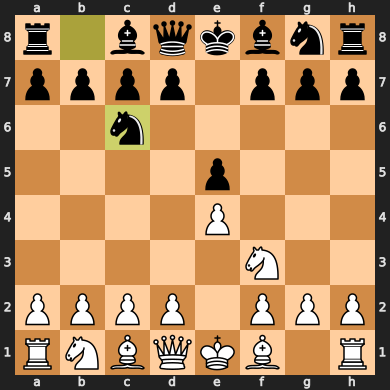

['R', 'N', 'B', 'Q', 'K', 'B', 'EMPTY', 'R', 'P', 'P', 'P', 'P', 'EMPTY', 'P', 'P', 'P', 'EMPTY', 'EMPTY', 'EMPTY', 'EMPTY', 'EMPTY', 'N', 'EMPTY', 'EMPTY', 'EMPTY', 'EMPTY', 'EMPTY', 'EMPTY', 'P', 'EMPTY', 'EMPTY', 'EMPTY', 'EMPTY', 'EMPTY', 'EMPTY', 'EMPTY', 'p', 'EMPTY', 'EMPTY', 'EMPTY', 'EMPTY', 'EMPTY', 'n', 'EMPTY', 'EMPTY', 'EMPTY', 'EMPTY', 'EMPTY', 'p', 'p', 'p', 'p', 'EMPTY', 'p', 'p', 'p', 'r', 'EMPTY', 'b', 'q', 'k', 'b', 'n', 'r']
Predicted move: Nc6


IllegalMoveError: illegal san: 'Nc6' in r1bqkbnr/pppp1ppp/2n5/4p3/4P3/5N2/PPPP1PPP/RNBQKB1R w KQkq - 2 3

In [13]:
sample_input_sequence = "e4 e5 Nf3 Nc6"
sample_input_sequence_list = sample_input_sequence.split(" ")
board = chess.Board()
for input_move in sample_input_sequence_list:
    board.push_san(input_move)
display(board)

board_flat_list = board_to_flat_list(board)
# Replace None in board_flat_list into "EMPTY"
board_flat_list = ["EMPTY" if (x is None or x == "None") else x for x in board_flat_list]
print(board_flat_list)

game_id = "1"
game_stage = determine_game_stage(len(sample_input_sequence_list))


# Encode the input sequence
input_sequence_encoded = [feature_categories.index(x)+1 for x in board_flat_list]

white_backline = len([piece for piece in board_flat_list if piece in ['B', 'K', 'N', 'P', 'Q', 'R']])
black_backline = len([piece for piece in board_flat_list if piece in ['b', 'k', 'n', 'p', 'q', 'r']])

full_row = input_sequence_encoded + [game_stage, white_backline, black_backline]

# Predict using the model
model.eval()
with torch.no_grad():
    input_tensor = torch.tensor(full_row, dtype=torch.float32).to(DEVICE)
    output = model(input_tensor)
    _, predicted = torch.max(output.data, 0)

    predicted_item = predicted.item()
    predicted_move = target_categories[predicted_item]
    print(f"Predicted move: {predicted_move}")

    board.push_san(predicted_move)
    display(board)
